In [ ]:

# 导入依赖并设置随机种子（为结果复现做准备）
import os, random, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 2025
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow: 2.20.0
Num GPUs Available: 0


In [ ]:

# 载入并预处理 MNIST 数据
# 数据形状：28x28 的灰度图，标签为 0-9 十类
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# 下载/读取数据（首次会自动下载到本地缓存）
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print("train_images:", train_images.shape, "train_labels:", train_labels.shape)
print("test_images:", test_images.shape, "test_labels:", test_labels.shape)

# 2.1 归一化到 [0,1] 并展开为 (样本数, 784)
x_train = (train_images.reshape((60000, 28*28)).astype("float32")) / 255.0
x_test  = (test_images.reshape((10000, 28*28)).astype("float32")) / 255.0

# 2.2 两种标签方案：
y_train_cat = to_categorical(train_labels)   # One-Hot，用于 categorical_crossentropy
y_test_cat  = to_categorical(test_labels)

y_train_int = train_labels.copy()            # 整数标签，用于 sparse_categorical_crossentropy
y_test_int  = test_labels.copy()

print("x_train:", x_train.shape, "y_train_cat:", y_train_cat.shape, "y_train_int:", y_train_int.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
train_images: (60000, 28, 28) train_labels: (60000,)
test_images: (10000, 28, 28) test_labels: (10000,)
x_train: (60000, 784) y_train_cat: (60000, 10) y_train_int: (60000,)



## 3. 基线模型
- 结构：`Dense(512, relu) -> Dense(10, softmax)`  
- 优化器：`RMSprop`  
- 损失：`categorical_crossentropy`（配合 One-Hot 标签）


In [3]:

def build_baseline(input_dim=784):
    model = keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

baseline = build_baseline()
baseline.summary()


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

#训练基线模型
history = baseline.fit(
    x_train, y_train_cat,
    epochs=5, batch_size=128,
    validation_split=0.1, verbose=2
)


Epoch 1/5
422/422 - 1s - 2ms/step - accuracy: 0.9191 - loss: 0.2808 - val_accuracy: 0.9613 - val_loss: 0.1317
Epoch 2/5
422/422 - 0s - 1ms/step - accuracy: 0.9663 - loss: 0.1164 - val_accuracy: 0.9690 - val_loss: 0.1001
Epoch 3/5
422/422 - 0s - 1ms/step - accuracy: 0.9785 - loss: 0.0749 - val_accuracy: 0.9742 - val_loss: 0.0831
Epoch 4/5
422/422 - 0s - 1ms/step - accuracy: 0.9856 - loss: 0.0526 - val_accuracy: 0.9767 - val_loss: 0.0768
Epoch 5/5
422/422 - 0s - 1ms/step - accuracy: 0.9905 - loss: 0.0379 - val_accuracy: 0.9790 - val_loss: 0.0761


In [ ]:

#在测试集评估
test_loss, test_acc = baseline.evaluate(x_test, y_test_cat, verbose=0)
print(f"[Baseline] test_loss={test_loss:.4f}, test_acc={test_acc:.4f}")


[Baseline] test_loss=0.0700, test_acc=0.9784


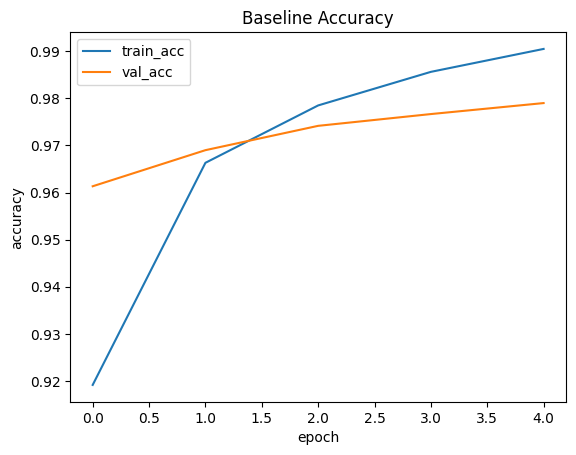

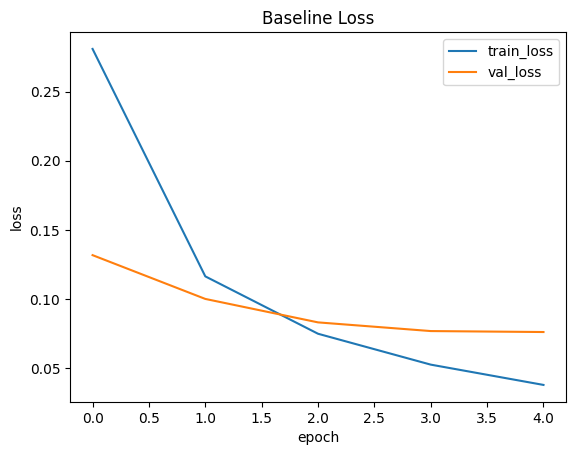

In [ ]:

#训练曲线可视化
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.title('Baseline Accuracy'); plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Baseline Loss'); plt.show()



## 4. 用测试集做预测并可视化


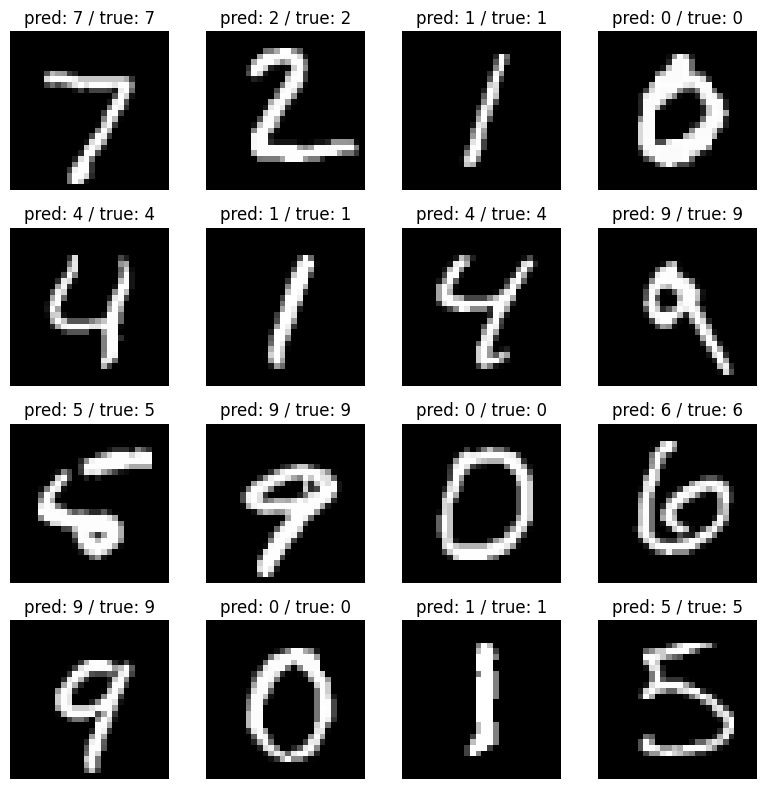

In [7]:

pred_probs = baseline.predict(x_test[:16], verbose=0)
preds = pred_probs.argmax(axis=1)

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f"pred: {preds[i]} / true: {test_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()



## 5. 调参实验


In [ ]:

def build_mlp(input_dim=784, hidden_layers=2, units=128, activation='relu',
              dropout_rate=0.0, optimizer='rmsprop', loss='categorical_crossentropy',
              use_sparse=False):
    # 构建一个多层感知机（MLP）。
    # - hidden_layers: 隐层数（2 或 3）
    # - units: 每层神经元个数（如 32/64/128）
    # - activation: 'relu' 或 'tanh'
    # - dropout_rate: 若>0，则在每个隐层后加入 Dropout
    # - optimizer: 'rmsprop' 或 'adam'
    # - loss: 'categorical_crossentropy' 或 'sparse_categorical_crossentropy'
    # - use_sparse: 若 True，标签使用整数版；否则使用 One-Hot
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for _ in range(hidden_layers):
        model.add(layers.Dense(units, activation=activation))
        if dropout_rate > 0.0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

#小型实验组合
experiments = [
    dict(name='2x64_relu_rmsprop_cat',  hidden_layers=2, units=64, activation='relu', dropout_rate=0.0, optimizer='rmsprop', loss='categorical_crossentropy', use_sparse=False, epochs=5, batch_size=128),
    dict(name='3x64_relu_rmsprop_cat',  hidden_layers=3, units=64, activation='relu', dropout_rate=0.0, optimizer='rmsprop', loss='categorical_crossentropy', use_sparse=False, epochs=5, batch_size=128),
    dict(name='2x128_relu_dropout_adam',hidden_layers=2, units=128,activation='relu', dropout_rate=0.5, optimizer='adam',    loss='categorical_crossentropy', use_sparse=False, epochs=5, batch_size=128),
    dict(name='2x64_tanh_adam_cat',     hidden_layers=2, units=64, activation='tanh',dropout_rate=0.0, optimizer='adam',    loss='categorical_crossentropy', use_sparse=False, epochs=5, batch_size=128),
    dict(name='2x64_relu_adam_sparse',  hidden_layers=2, units=64, activation='relu', dropout_rate=0.0, optimizer='adam',   loss='sparse_categorical_crossentropy', use_sparse=True, epochs=5, batch_size=128),
    dict(name='2x32_relu_rmsprop_cat_bs256',hidden_layers=2, units=32, activation='relu', dropout_rate=0.0, optimizer='rmsprop', loss='categorical_crossentropy', use_sparse=False, epochs=8, batch_size=256),
]

results = []

for cfg in experiments:
    print("\n=== Running", cfg['name'], '===')
    model = build_mlp(hidden_layers=cfg['hidden_layers'],
                      units=cfg['units'],
                      activation=cfg['activation'],
                      dropout_rate=cfg['dropout_rate'],
                      optimizer=cfg['optimizer'],
                      loss=cfg['loss'],
                      use_sparse=cfg['use_sparse'])
    if cfg['use_sparse']:
        y_train_used = y_train_int
        y_test_used  = y_test_int
    else:
        y_train_used = y_train_cat
        y_test_used  = y_test_cat

    history = model.fit(
        x_train, y_train_used,
        epochs=cfg['epochs'],
        batch_size=cfg['batch_size'],
        validation_split=0.1,
        verbose=0
    )
    test_loss, test_acc = model.evaluate(x_test, y_test_used, verbose=0)
    results.append({
        **cfg,
        'val_best_acc': float(np.max(history.history['val_accuracy'])),
        'test_acc': float(test_acc),
        'test_loss': float(test_loss),
    })
    #释放模型
    del model

results_df = pd.DataFrame(results).sort_values(by='test_acc', ascending=False).reset_index(drop=True)
results_df



=== Running 2x64_relu_rmsprop_cat ===

=== Running 3x64_relu_rmsprop_cat ===

=== Running 2x128_relu_dropout_adam ===

=== Running 2x64_tanh_adam_cat ===

=== Running 2x64_relu_adam_sparse ===

=== Running 2x32_relu_rmsprop_cat_bs256 ===


,name,hidden_layers,units,activation,dropout_rate,optimizer,loss,use_sparse,epochs,batch_size,val_best_acc,test_acc,test_loss
0,3x64_relu_rmsprop_cat,3,64,relu,0.0,rmsprop,categorical_crossentropy,False,5,128,0.973333,0.9735,0.087433
1,2x64_tanh_adam_cat,2,64,tanh,0.0,adam,categorical_crossentropy,False,5,128,0.970167,0.9692,0.099735
2,2x128_relu_dropout_adam,2,128,relu,0.5,adam,categorical_crossentropy,False,5,128,0.973500,0.9685,0.106939
3,2x64_relu_adam_sparse,2,64,relu,0.0,adam,sparse_categorical_crossentropy,True,5,128,0.973833,0.9680,0.098967
4,2x64_relu_rmsprop_cat,2,64,relu,0.0,rmsprop,categorical_crossentropy,False,5,128,0.967333,0.9638,0.117440
5,2x32_relu_rmsprop_cat_bs256,2,32,relu,0.0,rmsprop,categorical_crossentropy,False,8,256,0.964667,0.9593,0.138157


In [ ]:

#显示实验结果表格
results_df


,name,hidden_layers,units,activation,dropout_rate,optimizer,loss,use_sparse,epochs,batch_size,val_best_acc,test_acc,test_loss
0,3x64_relu_rmsprop_cat,3,64,relu,0.0,rmsprop,categorical_crossentropy,False,5,128,0.973333,0.9735,0.087433
1,2x64_tanh_adam_cat,2,64,tanh,0.0,adam,categorical_crossentropy,False,5,128,0.970167,0.9692,0.099735
2,2x128_relu_dropout_adam,2,128,relu,0.5,adam,categorical_crossentropy,False,5,128,0.973500,0.9685,0.106939
3,2x64_relu_adam_sparse,2,64,relu,0.0,adam,sparse_categorical_crossentropy,True,5,128,0.973833,0.9680,0.098967
4,2x64_relu_rmsprop_cat,2,64,relu,0.0,rmsprop,categorical_crossentropy,False,5,128,0.967333,0.9638,0.117440
5,2x32_relu_rmsprop_cat_bs256,2,32,relu,0.0,rmsprop,categorical_crossentropy,False,8,256,0.964667,0.9593,0.138157


In [ ]:

#选取当前表格中的最优实验，重新训练并保存模型（可选）
best_cfg = results_df.iloc[0].to_dict()
print('Best config =', best_cfg['name'])

best_model = build_mlp(hidden_layers=int(best_cfg['hidden_layers']),
                       units=int(best_cfg['units']),
                       activation=best_cfg['activation'],
                       dropout_rate=float(best_cfg['dropout_rate']),
                       optimizer=best_cfg['optimizer'],
                       loss=best_cfg['loss'],
                       use_sparse=bool(best_cfg['use_sparse']))

if bool(best_cfg['use_sparse']):
    y_train_used = y_train_int
    y_test_used  = y_test_int
else:
    y_train_used = y_train_cat
    y_test_used  = y_test_cat

best_model.fit(x_train, y_train_used, epochs=int(best_cfg['epochs']),
               batch_size=int(best_cfg['batch_size']), verbose=0)

# 再评估一次
test_loss, test_acc = best_model.evaluate(x_test, y_test_used, verbose=0)
print(f"[BEST] test_loss={test_loss:.4f}, test_acc={test_acc:.4f}")

# 保存模型（h5）
best_model.save('mnist_best_model.h5')
print('Saved -> mnist_best_model.h5')


Best config = 3x64_relu_rmsprop_cat


[BEST] test_loss=0.1056, test_acc=0.9684
Saved -> mnist_best_model.h5



## 6. 实验记录与结论

- **隐层数**：尝试3层；  
- **每层神经元**：64；  
- **激活函数**：`relu`；  
- **Dropout 比例**：0；  
- **损失函数**：`categorical_crossentropy`；  
- **优化器**：`RMSprop`；  
- **训练轮次 / 批大小**：5、128； 
- **最终测试集准确率**：0.973333；
